In [1]:
!pip install torch torchvision transformers 
!pip install -q pycocotools
!pip install -q albumentations

In [2]:
import torch
import torchvision


**Setting up a the data pipeline**

In [3]:
import json
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [4]:
train_data = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
test_data = "/kaggle/input/coco-2017-dataset/coco2017/test2017"
val_data = "/kaggle/input/coco-2017-dataset/coco2017/val2017"

In [5]:
train_annotations = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"
val_annotations = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json"

**Data Augmentations**

In [23]:
from torchvision import transforms



transformer = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
    ])




**Data Loader**

In [24]:
import os
import cv2
from PIL import Image
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom Dataset class to laoad Image - Caption pairs
class COCOTextImageDataset(Dataset):
    def __init__(self, coco, image_dir, transforms=None):
        self.coco = coco
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_ids = list(coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Get Image ID
        image_id = self.image_ids[idx]

        # Load Image
        image_info = self.coco.imgs[image_id]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Transforms
        if self.transforms:
            image = Image.fromarray(image)  
            image = self.transforms(image)

        # Get Captions
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)
        captions = [ann['caption'] for ann in annotations]
        caption = random.choice(captions) if captions else "" # returns a random caption of the image


        # Return image caption and image
        return image, captions



In [25]:
train_coco = COCO(train_annotations)
val_coco = COCO(val_annotations)

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [26]:
train_dataset = COCOTextImageDataset(train_coco, train_data, transforms=transformer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataset = COCOTextImageDataset(val_coco, val_data, transforms=transformer)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

Image shape: torch.Size([3, 224, 224])
Caption: ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']


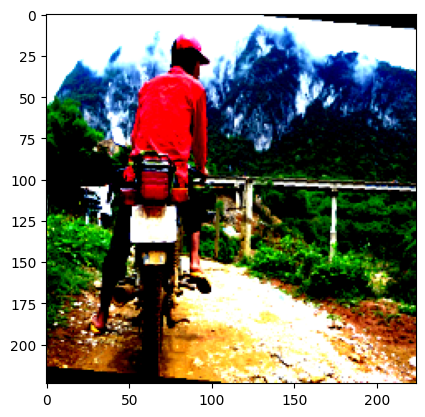

In [28]:
import matplotlib.pyplot as plt
image, caption = train_dataset[0]
print("Image shape:", image.shape) 
print("Caption:", caption)
plt.imshow(image.permute(1, 2, 0).numpy() if isinstance(image, torch.Tensor) else image)
plt.show()

In [11]:
torch.save(val_dataset, '/kaggle/working/val_dataset.pt')
torch.save(train_dataset, '/kaggle/working/train_dataset.pt')